# Finite state space

Phylogenetic tree initial analysis with observations at the leaf nodes, following the finite state space example and algorithm in https://arxiv.org/abs/2203.04155 .

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
print(sys.executable)

import hyperiax
import jax
import math
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import product_fuse_children
from hyperiax.mcmc import Parameter, ParameterStore, UniformParameter, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

/Users/sara/anaconda3/envs/hyperiax/bin/python


In [29]:
key = PRNGKey(42)

Function for children value multiplication with vector normalization 

In [30]:
def norm_product_fuse(**kwargs):
    value = reduce(lambda x, y: x * y, kwargs['child_value']).reshape(-1)
    new_value = value / jnp.linalg.norm(value)
    log_sum = math.log(jnp.linalg.norm(value))
    return {'value': new_value, 'log_sum': log_sum}

In [31]:
# Update Parameter class for Uniform Distribution
class UniformParameter(Parameter):
    def __init__(self, value, min=0., max=1., keep_constant=False) -> None:
        super().__init__(value)
        self.min = min
        self.max = max
        self.keep_constant = keep_constant

    def propose(self, key):
        if self.keep_constant:
            return self

        return UniformParameter(jax.random.uniform(key, minval=self.min, maxval=self.max), self.min, self.max,
                                self.keep_constant)

    def update(self, value, accepted):
        if accepted:
            self.value = value

    def log_prior(self):
        return 0.

# Create tree
First, we initialize the tree with for each node the type, value, and log_sum (norm).

In [32]:
# create tree and initialize with noise

from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList

# example tree, see Figure 1 / Figure 4 tree in https://arxiv.org/abs/2203.04155
root = TreeNode();  # x_{-1}
x0 = TreeNode(); x0.parent = root; root.children = ChildList([x0])
x1 = TreeNode(); x1.parent = x0;
x3 = TreeNode(); x3.parent = x0;
x0.children = ChildList([x1, x3])
x2 = TreeNode(); x2.parent = x1; x1.children = ChildList([x2])
v3 = TreeNode(); v3.parent = x2; x2.children = ChildList([v3])
x4 = TreeNode(); x4.parent = x3;
v2 = TreeNode(); v2.parent = x3; x3.children = ChildList([x4, v2])
v1 = TreeNode(); v1.parent = x4; x4.children = ChildList([v1])
v1.children = v2.children = v3.children = ChildList()

tree = HypTree(root)
print('Tree:', tree)
tree.plot_tree_text()

# types for correct transitions
troot = 0; tinner_node = 1; tleaf_node = 2;
tree.root['type'] = troot
x1['type'] = x2['type'] = x3['type'] = x4['type'] = tinner_node
v1['type'] = v2['type'] = v3['type'] = tleaf_node

# number of states
R = 3

# root 
tree.root['value'] = jnp.zeros(R)
x0['type'] = troot

# observations
v1['value'] = jnp.eye(R)[0]
v2['value'] = jnp.eye(R)[1]
v3['value'] = jnp.eye(R)[2]

# Initialize log_sum as data of all nodes
for i in tree.iter_bfs():
    i['log_sum'] = 0
    
# initial state prior
pi1 = pi2 = pi3 = 1 / 3;
km10 = lambda params: jnp.diag([pi1, pi2, pi3])
# inner node
kst = lambda params: jnp.array([[1. - params['theta'], params['theta'], 0.],
                                [.25, .5, .25],
                                [.4, .3, .3]])
# leaves
lambdi = lambda params: jnp.array([[1., 1., 0.],
                                   [1., 1., 0.], 
                                   [0., 0., 1.]])

# transitions inside the tree
def transition(value, type, params):
    return jax.lax.cond(type == tinner_node,
                        lambda: jnp.dot(kst(params), value),
                        lambda: jax.lax.cond(type == tleaf_node,
                                             lambda: jnp.dot(lambdi(params), value),
                                             lambda: jnp.array([pi1, pi2, pi3])
                                            )
                       )


Tree: HypTree with 5 levels and 9 nodes
 *
 │
 *
┌┴─┐
*  * 
│ ┌┴┐
* * *
│ │  
* *


Parameter for the inner transition kernel.

In [33]:
# parameter, theta with uniform prior
params = ParameterStore({
    'theta': UniformParameter(.5),  # theta parameter for kst
})

We now define the backwards filter through the up and fuse functions. In this case, the up operation is first a matrix multiplication and then a dot product of the children.

In [34]:
# backwards filter 
def up(value, type, params, **args):
    def f(value, type):
        return {'value': transition(value, type, params)}
    return jax.vmap(f)(value, type)

We create the model and executor for the backwards filter (up) with the normalized product of the values after joining them.

In [35]:
# create model and executor
upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
upexec = LevelwiseTreeExecutor(upmodel)

In [36]:
# execture backwards filter
utree = upexec.up(tree, params.values())

# prior is also normalized which I avoided to compare the results better
utree.root.data['log_sum'] = 0
utree.root.data['value'] = jnp.array([pi1, pi2, pi3])

# print results and calculate total to be added later
total_log_sum = 0
for node in utree.iter_bfs():
    print(node.data)
    total_log_sum += node.data['log_sum']


{'type': 0, 'value': Array([0.33333334, 0.33333334, 0.33333334], dtype=float32), 'log_sum': 0}
{'type': 0, 'log_sum': -0.9150115257595711, 'value': Array([0.5594453 , 0.63936603, 0.527477  ], dtype=float32)}
{'type': 1, 'log_sum': -0.9402953096177683, 'value': Array([0.        , 0.6401844 , 0.76822126], dtype=float32)}
{'type': 1, 'log_sum': -0.12343010665625444, 'value': Array([0.8, 0.6, 0. ], dtype=float32)}
{'type': 1, 'log_sum': 0.0, 'value': Array([0., 0., 1.], dtype=float32)}
{'type': 1, 'log_sum': 0.3465735731657015, 'value': Array([0.70710677, 0.70710677, 0.        ], dtype=float32)}
{'type': 2, 'value': Array([0., 1., 0.], dtype=float32), 'log_sum': 0}
{'type': 2, 'value': Array([0., 0., 1.], dtype=float32), 'log_sum': 0}
{'type': 2, 'value': Array([1., 0., 0.], dtype=float32), 'log_sum': 0}


# Likelihood Computation
We compute the likelihood as the dot product of the prior kernel and the value at the root, plus the norms of the normalized values.

In [37]:
# Likelihood = log(prior * h0) + log(sum norm)
prior_vec = utree.root.data['value']
h0_vec = utree.root.children[0].data['value']

log_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
print(f"The likelihoog is {log_lik}")

The likelihoog is -2.1848020344253407


# Result Comparison
Log-likelihood results for different values of theta.

In [48]:
likelihood = []
theta_range = np.linspace(0.02, 0.95, 1000)
for new_theta in theta_range:
    # Update theta
    params['theta'].update(float(new_theta), True)

    # create model and executor
    upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
    upexec = LevelwiseTreeExecutor(upmodel)

    # execture backwards filter
    new_tree = upexec.up(tree, params.values())

    # Compute Log-Likelihood
    total_log_sum = 0
    for node in new_tree.iter_bfs():
        total_log_sum += node.data['log_sum']

    prior_vec = new_tree.root.data['value']
    h0_vec = new_tree.root.children[0].data['value']

    # New Likelihood
    new_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
    likelihood.append(new_lik)

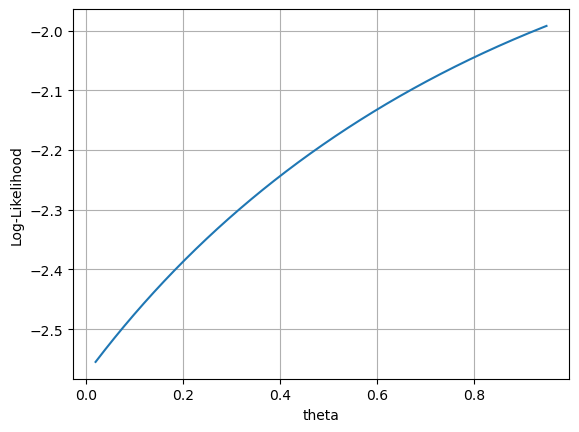

In [50]:
# Plot Parameter Comparison
plt.plot(theta_range, likelihood)
plt.xlabel('theta')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.savefig("Simple_LogLike.png")
plt.show()